# Convolutional Neural Network (CNN) Demonstration

This notebook demonstrates the implementation of a Convolutional Neural Network (CNN) using the modularNN framework.
We'll train a lightweight CNN on the MNIST dataset for handwritten digit classification.

We will implement, train, and evaluate a lightweight Convolutional Neural Network on the MNIST dataset using our modularNN framework. The CNN architecture will consist of:

1. Two small convolutional blocks (Conv -> ReLU -> Pooling) with limited filters
2. Flattening layer to convert 3D feature maps to 1D vectors
3. A compact fully connected layer with ReLU activation
4. SoftMax output for multi-class classification

The CNN will learn to recognize handwritten digits (0-9) from the MNIST dataset, using fewer than 60,000 trainable parameters.

In [2]:
import matplotlib.pyplot as plt
import os.path
import numpy as np
import sys
sys.path.append('../..')

from Helpers.NeuralNetwork import NeuralNetwork

from Data import DatasetClasses

from Helpers import Helpers
from Layers.Dropout import Dropout
from Layers.BatchNormalization import BatchNormalization
from Layers.FullyConnected import FullyConnected
from Layers.Activations import SoftMax
from Layers.Activations import ReLU
from Layers.Conv import Conv
from Layers.Pooling import Pooling
from Layers.Flatten import Flatten
from Layers.Initializers import He, Constant

from Optimization.Optimizers import Sgd, Adam
from Optimization.Loss import CrossEntropyLoss
from Optimization.Constraints import L2_Regularizer

## 1. Load MNIST Dataset

We'll use the MNIST dataset for handwritten digit classification. This dataset contains 60,000 training images and 10,000 testing images of handwritten digits from 0 to 9.


dataset Informations:
--------------------------------------------------
Training samples: 45500
Sample shape: (1, 28, 28)
Number of classes: 10
Test samples: 14000
Dataset size in memory: 355.90 MB


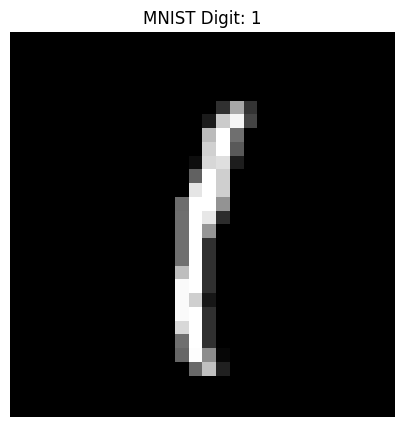

In [3]:
# Define batch size for training
batch_size = 128

# Load MNIST dataset
mnist_data = DatasetClasses.MNISTData(batch_size)

# Show dataset information
mnist_data.print_dataset_info()
# Display a random sample
# mnist_data.plot_random_training_sample()

## 2. Dataset Information

Let's examine the dataset to understand its structure better.

Training data shape: (45500, 1, 28, 28)
Training labels shape: (45500, 10)
Test data shape: (14000, 1, 28, 28)
Test labels shape: (14000, 10)
Number of categories: 10


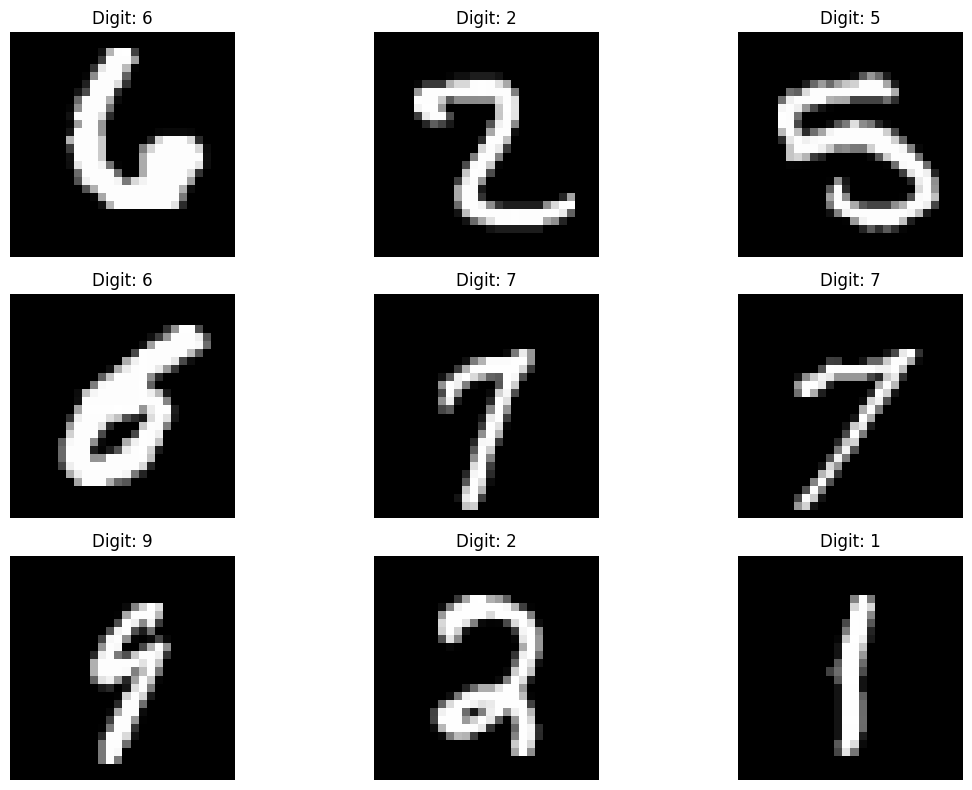

In [4]:
# Get train and test data shapes
train_data, train_labels = mnist_data._input_tensor_train, mnist_data._label_tensor_train
test_data, test_labels = mnist_data._input_tensor_test, mnist_data._label_tensor_test

print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Number of categories: {train_labels.shape[1]}")

# Show a few sample images
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    # MNIST has grayscale images (single channel)
    img = train_data[i].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    digit = np.argmax(train_labels[i])
    plt.title(f"Digit: {digit}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 3. Create a Lightweight Convolutional Neural Network

We'll define a small CNN with the following architecture:
- Convolutional layer with 6 3x3 filters and stride 1
- ReLU activation function
- Max pooling layer with 2x2 pooling and stride 2
- Convolutional layer with 12 3x3 filters and stride 1
- ReLU activation function
- Max pooling layer with 2x2 pooling and stride 2
- Flatten layer to convert 3D feature maps to a 1D vector
- Fully connected layer with 30 neurons
- ReLU activation function
- Fully connected output layer with 10 neurons (for 10 digits)
- SoftMax activation for classification

This architecture has significantly fewer parameters than our previous model (less than 60,000).

In [5]:
def build_fc_dominant_cnn(num_categories):
    #performs not that well (90% after 650s - 2000 iterations)
    learning_rate = 0.0001 # Learning rate for Adam optimizer
    optimizer = Adam(learning_rate)
    regularizer = L2_Regularizer(alpha=0.0001)  # Light regularization
    optimizer.add_regularizer(regularizer)
    
    weights_initializer = He()
    bias_initializer = Constant(0.1)  # Small constant for bias initialization
    net = NeuralNetwork(optimizer, weights_initializer, bias_initializer)
    
    # Block 1
    net.append_layer(Conv((1, 1), (1, 3, 3), 6))  # Only 6 filters in first conv layer
    net.append_layer(ReLU())
    net.append_layer(Pooling((2, 2), 2)) # 28x28 → 14x14 (2x2 pooling with stride 2)
    
    # Block 2
    net.append_layer(Conv((1, 1), (6, 3, 3), 12))  # Only 12 filters in second conv layer
    net.append_layer(ReLU())
    net.append_layer(Pooling((2, 2), 2)) # 14x14 → 7x7
    
    # Flatten
    net.append_layer(Flatten())
    
    # FC layers - Small fully connected layer
    net.append_layer(FullyConnected(12 * 7 * 7, 30))  # Only 30 neurons in FC layer
    net.append_layer(ReLU())
    net.append_layer(Dropout(0.2))  # Light dropout
    net.append_layer(FullyConnected(30, num_categories))
    net.append_layer(SoftMax())
    
    # Loss
    net.loss_layer = CrossEntropyLoss()
    
    return net

# Calculation of parameters:
# Conv1: (3*3*1 + 1) * 6 = 60 parameters
# Conv2: (3*3*6 + 1) * 12 = 660 parameters
# FC1: (12*7*7 + 1) * 30 = 17,670 parameters
# FC2: (30 + 1) * 10 = 310 parameters
# Total: 18,700 parameters

In [6]:
def build_cnn(num_categories):
    learning_rate = 0.0001  # Learning rate for Adam optimizer
    optimizer = Adam(learning_rate)
    regularizer = L2_Regularizer(alpha=0.0001)  # Light regularization
    optimizer.add_regularizer(regularizer)
    
    weights_initializer = He()
    bias_initializer = Constant(0.1)  # Small constant for bias initialization
    net = NeuralNetwork(optimizer, weights_initializer, bias_initializer)
    
    # Block 1: 28x28 → 14x14
    net.append_layer(Conv((1, 1), (1, 3, 3), 8))  # 8 filters
    net.append_layer(ReLU())
    net.append_layer(Pooling((2, 2), 2))  # 28x28 → 14x14

    # Block 2: 14x14 → 7x7
    net.append_layer(Conv((1, 1), (8, 3, 3), 16))  # 16 filters
    net.append_layer(ReLU())
    net.append_layer(Pooling((2, 2), 2))  # 14x14 → 7x7

    # Block 3: 7x7 → 3x3
    net.append_layer(Conv((1, 1), (16, 3, 3), 32))  # 32 filters
    net.append_layer(ReLU())
    net.append_layer(Pooling((2, 2), 2))  # 7x7 → 3x3

    # Flatten: 32×3×3 = 288 features
    net.append_layer(Flatten())

    # Fully Connected Layers
    net.append_layer(FullyConnected(32 * 3 * 3, 40))  # Smaller FC
    net.append_layer(ReLU())
    net.append_layer(Dropout(0.2))  # Light dropout
    net.append_layer(FullyConnected(40, num_categories))
    net.append_layer(SoftMax())

    # Loss
    net.loss_layer = CrossEntropyLoss()

    return net

<class 'Helpers.NeuralNetwork.NeuralNetwork'>


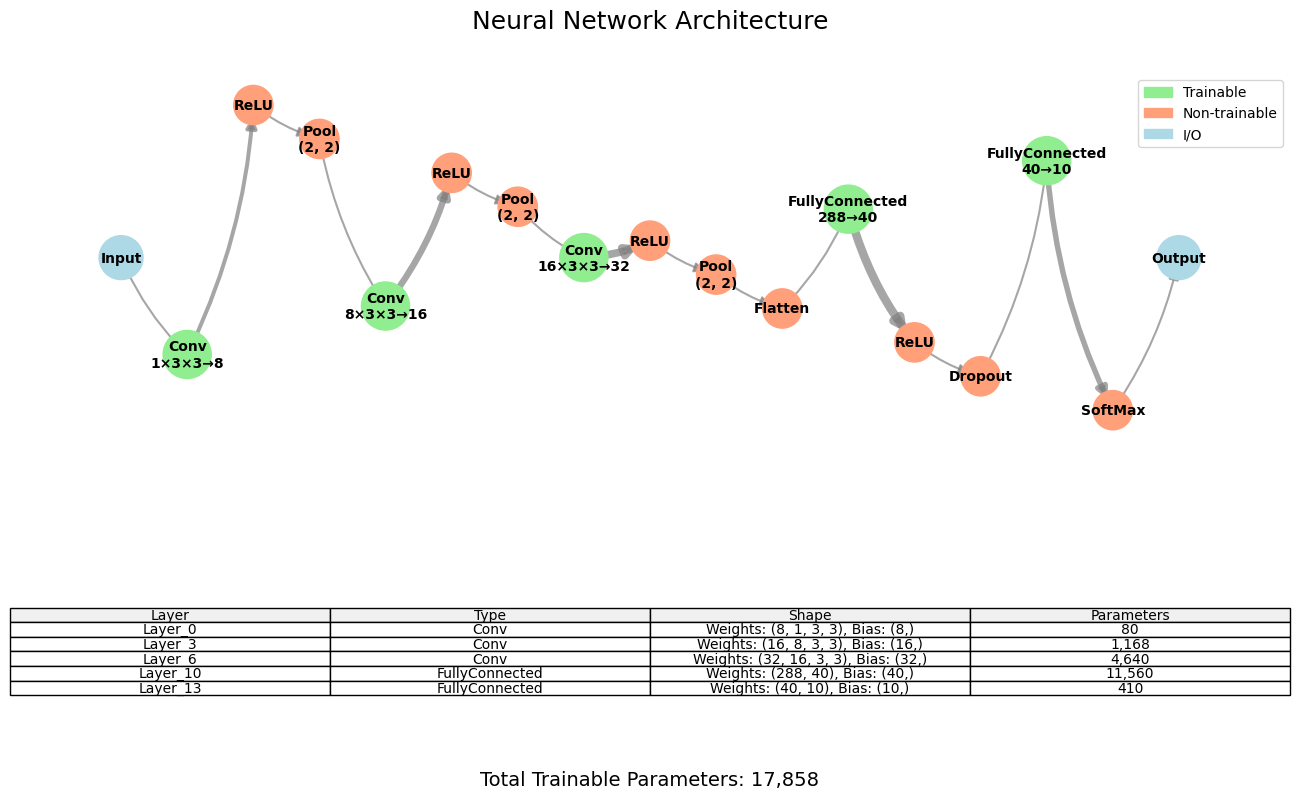

Détection automatique du type de problème: classification (basé sur CrossEntropyLoss)
Validation set detected and will be used for display.
 Iteration |         Loss |  Train Acc (%) |  Val Acc (%) | Elapsed Time
-----------------------------------------------------------------
         0 |   647.034098 |           9.90 |        10.80 | 0.86s
        10 |   547.145750 |           9.80 |        10.10 | 10.67s
        20 |   541.087112 |          11.80 |        10.30 | 18.57s
        30 |   410.868547 |           9.60 |        10.90 | 26.67s
        40 |   392.429839 |          11.20 |        13.20 | 34.48s
        50 |   333.436150 |          12.40 |        15.30 | 42.19s
        60 |   323.496976 |          16.70 |        14.70 | 49.82s
        70 |   301.209829 |          15.90 |        14.30 | 57.75s
        80 |   309.144284 |          19.40 |        17.50 | 65.56s
        90 |   292.187378 |          22.20 |        21.80 | 73.46s
       100 |   296.977238 |          25.40 |        

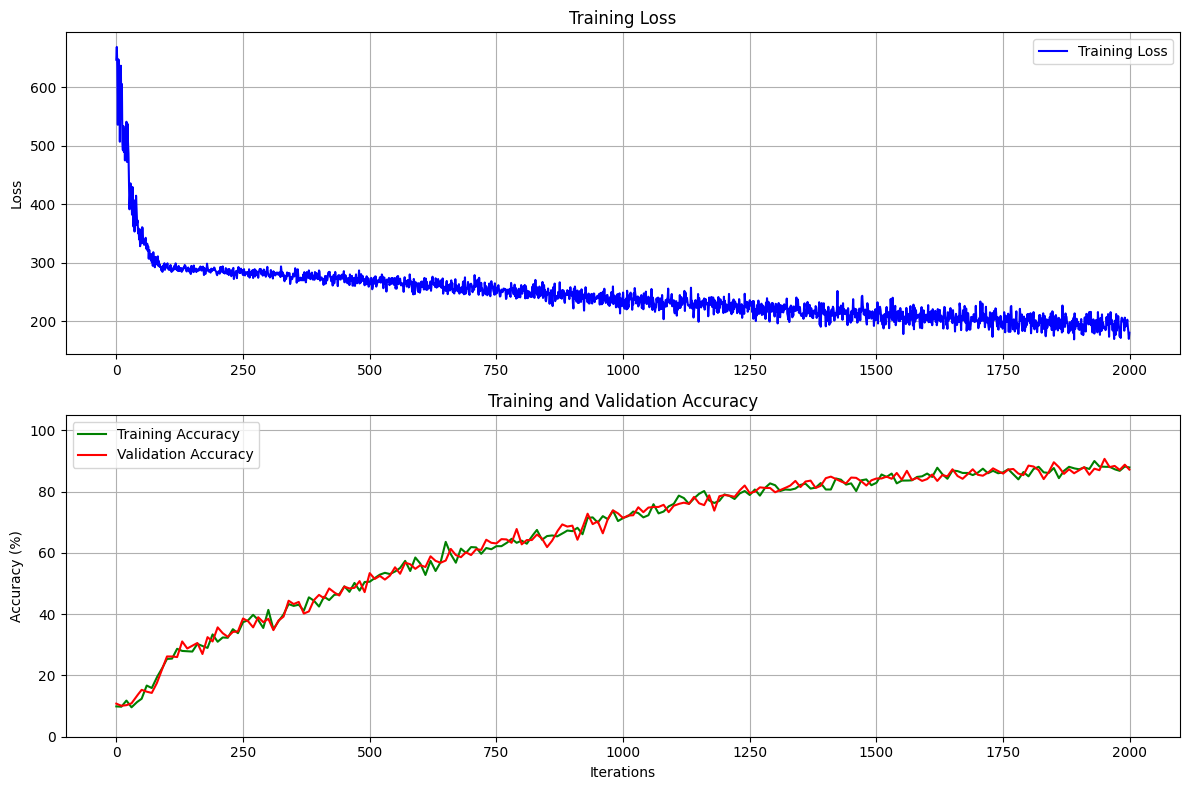


On the MNIST dataset, we achieve an accuracy of: 87.45%


In [ ]:
num_categories = train_labels.shape[1]  # 10 for MNIST
net = build_cnn(num_categories)
net.data_layer = mnist_data

print(type(net))
net.plot()

# Define training parameters
num_epochs = 2000  # Training for more epochs to compensate for smaller model size (takes about 15min)

net.train(num_epochs)

# Get the test set
data, labels = net.data_layer.get_test_set()

# Test the network on the test set
results = net.test(data)
accuracy = Helpers.calculate_accuracy(results, labels)
print('\nOn the MNIST dataset, we achieve an accuracy of: ' + str(accuracy * 100) + '%')

## 6. Visualize Model Predictions

Let's see how our lightweight model performs on some test examples

In [6]:
# Get test data and make predictions
test_data, test_targets = mnist_data.get_test_set()
test_predictions = net.test(test_data)

# Plot some test examples and their predictions
num_examples = 9
plt.figure(figsize=(15, 10))

# Get random indices from test set
random_indices = np.random.choice(test_data.shape[0], num_examples, replace=False)

for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i+1)
    
    # Display the image
    img = test_data[idx].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    
    # Get true and predicted classes
    true_class = np.argmax(test_targets[idx])
    pred_class = np.argmax(test_predictions[idx])
    
    # Get probabilities for the prediction
    pred_prob = test_predictions[idx][pred_class]
    
    # Set title color based on correctness
    title_color = 'green' if true_class == pred_class else 'red'
    
    # Add title with prediction info
    plt.title(f"True: {true_class}\nPred: {pred_class} ({pred_prob:.2f})", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'net' is not defined

## 7. Create Confusion Matrix

Let's visualize the performance using a confusion matrix

In [5]:
try:
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Get true and predicted classes
    y_true = np.argmax(test_targets, axis=1)
    y_pred = np.argmax(test_predictions, axis=1)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=range(10), 
                yticklabels=range(10))
    plt.xlabel('Predicted Digit')
    plt.ylabel('True Digit')
    plt.title('Confusion Matrix for MNIST Digits')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("sklearn and/or seaborn not available. Install with pip to visualize confusion matrix.")

NameError: name 'test_targets' is not defined